In [ ]:
#pre-processing pipeline
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

sc = StandardScaler() 
te = TargetEncoder() #to feature engineer selling club and buying club averages, without data leakage
    
pre_process = Pipeline([
    ('te', te),
    ('sc', sc)

])

from sklearn.linear_model import Lasso
estimator = Lasso(alpha = 0.01)
mod_pipeline = Pipeline([
    ('pre-process', pre_process),
    ('estimator', estimator)
])

# cv = KFold(n_splits=5, shuffle=True, random_state=0)
# scores = cross_val_score(mod_pipeline, X_train_fee, y_train_fee, cv = cv)

# mod_pipeline.fit_transform(X_train_fee,y_train_fee)

# Bias Auditing

In [2528]:
## How do we choose the threshold for market value?; we could do an even tier system??

In [2529]:
value_all_players["Value"].mean() #use the mean i guess

6735124.561403509

In [2530]:
#value_all_players["Value"].median() #use the median, maybe; there's some crazy outliers pushing the mean up i guess

In [2531]:
#add value threshold and drop value, drop nationality (need a dataset with nationality), predict value threshold

In [2532]:
value_all_players["ValueThreshold"] = value_all_players['Value'] < 4100000.0

In [2533]:
from sklearn.model_selection import train_test_split
all_train, all_test = train_test_split(value_all_players, test_size = .2, shuffle = True)

#final_value_all_players = pd.DataFrame(at_test, columns = ["Name"])
#final_value_all_players["actual"] = at_test['Value'].copy()


#getting the feature matrix and  target vector and deleting it from feature matrix

X_train_all = all_train.dropna(how='any', inplace=True)
X_train_all = all_train.drop(["Value"], axis = 1)
X_train_all = all_train.drop(["ValueThreshold"], axis = 1)
y_train_all = all_train["ValueThreshold"]



X_test_all = all_test.dropna(how='any', inplace=True)
X_test_all = all_test.drop(["Value"], axis = 1)
X_test_all = all_test.drop(["ValueThreshold"], axis = 1)
y_test_all = all_test["ValueThreshold"]

X_train_all = X_train_all.drop(["field_position"], axis = 1)
X_train_all = X_train_all.drop(["Name"], axis = 1)




X_test_all = X_test_all.drop(["field_position"], axis = 1)
X_test_all = X_test_all.drop(["Name"], axis = 1)

In [2534]:
#use classification model, try different ones

In [2535]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf_class = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_class.fit(X_train_all, y_train_all)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [2536]:
clf_class.score(X_test_all, y_test_all)

0.9525691699604744

In [2537]:
#gather predictions
predictions = clf_class.predict(X_test_all)
actual = y_test_all

In [2538]:
(predictions == actual).mean()

0.9525691699604744

In [2539]:
bias_ds = all_test.copy()
bias_ds.rename(columns={'ValueThreshold':'Actual'}, inplace=True) #rename ValueThreshold to Actual
bias_ds["Predicted"] = predictions

In [2540]:
bias_ds.head(3)

Name  Age  Overall_rating  Potential  Years_Left field_position  \
3232         Bobô   33              73         73         1.0       Attacker   
3445  Víctor Díaz   30              72         72         3.0       Defender   
1582     Ó. Trejo   30              76         76         1.0     Midfielder   

      Total_stats      Value     Wage  Total_attacking  ...  Weak_foot  \
3232         1775  2500000.0  15000.0              356  ...          3   
3445         1893  2200000.0   7000.0              302  ...          3   
1582         2080  7000000.0  20000.0              357  ...          4   

      Skill_moves  Pace_Diving  Shooting_Handling  Passing_Kicking  \
3232            3           64                 73               63   
3445            3           71                 56               65   
1582            4           70                 72               74   

      Dribbling_Reflexes  Defending_Pace  Physical_Positioning  Actual  \
3232                  69              29                    68    True   
3445                  66              69                    79    True   
1582                  80              65                    74   False   

      Predicted  
3232       True  
3445       True  
1582      False  

[3 rows x 60 columns]

In [2541]:
group_test = bias_ds["field_position"]

In [2542]:
group_test == "Attacker"

3232     True
3445    False
1582    False
5674    False
1494    False
        ...  
3096    False
2770    False
2127    False
4870    False
5202    False
Name: field_position, Length: 1012, dtype: bool

### Calibration

As defined by Chouldechova in [this paper](https://via.hypothes.is/https://arxiv.org/pdf/1703.00056.pdf), "a score S = S(x) is said to be well-calibrated if it reflects the same
likelihood of recidivism irrespective of the individuals’ group membership."

In our context, when we are doing binary classification for sex-based income, the calibration takes on the form of the PPV.
Namely, our model would be well-calibrated if the fraction of predicted individuals making >\\$50k who actually make >\\$50k is the same across groups.

In [2543]:
bias_ds_calibration = bias_ds.query("Predicted == True")

In [2544]:
bias_ds_calibration = bias_ds_calibration.groupby(["field_position", "Predicted"])["Actual"].mean().reset_index(name = "mean")

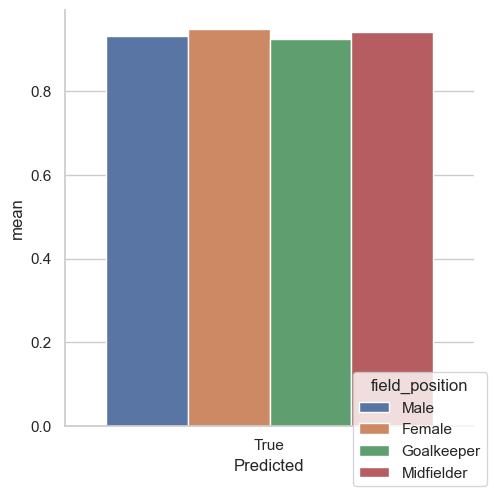

In [2545]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_ds_calibration, kind = "bar", x = "Predicted", y = "mean", hue = "field_position", legend_out = False)
new_labels = ['Male', 'Female']
for t, l in zip(p._legend.texts, new_labels):
    t.set_text(l)

sns.move_legend(p, "lower right")

### Error Rate Balance

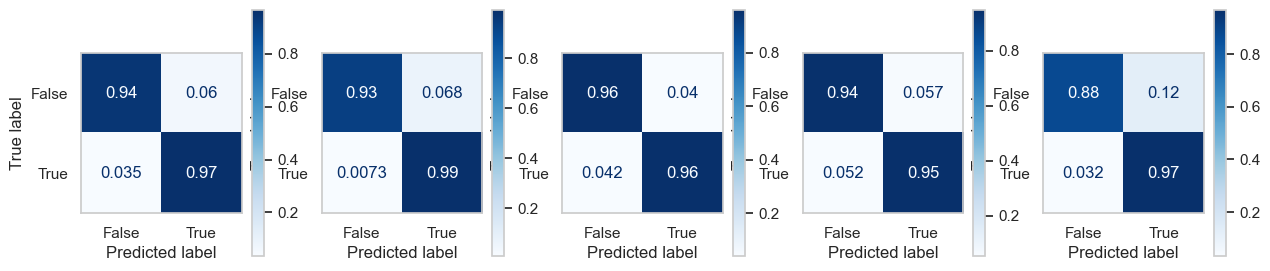

In [2546]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, axarr = plt.subplots(1, 5, figsize=(15,3.2), sharex = False, sharey = False)

cm1 = confusion_matrix(actual, predictions, labels=clf_class.classes_, normalize = "true")
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,
                              display_labels=clf_class.classes_)

cm2 = confusion_matrix(actual[group_test == "Attacker"], predictions[group_test == "Attacker"], labels=clf_class.classes_, normalize = "true")
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=clf_class.classes_)


cm3 = confusion_matrix(actual[group_test == "Midfielder"], predictions[group_test == "Midfielder"], labels=clf_class.classes_, normalize = "true")
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,
                              display_labels=clf_class.classes_)

cm4 = confusion_matrix(actual[group_test == "Defender"], predictions[group_test == "Defender"], labels=clf_class.classes_, normalize = "true")
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4,
                              display_labels=clf_class.classes_)

cm5 = confusion_matrix(actual[group_test == "Goalkeeper"], predictions[group_test == "Goalkeeper"], labels=clf_class.classes_, normalize = "true")
disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5,
                              display_labels=clf_class.classes_)

disp1.plot(ax=axarr[0], cmap = plt.cm.Blues)
axarr[0].grid(visible=None)

disp2.plot(ax=axarr[1], cmap = plt.cm.Blues)
axarr[1].grid(visible=None)

disp3.plot(ax=axarr[2], cmap = plt.cm.Blues)
axarr[2].grid(visible=None)

disp4.plot(ax=axarr[3], cmap = plt.cm.Blues)
axarr[3].grid(visible=None)

disp5.plot(ax=axarr[4], cmap = plt.cm.Blues)
axarr[4].grid(visible=None)

## Statistical Parity

In [2547]:
bias_ds_statParity = bias_ds.groupby(["field_position"], as_index=False)["Predicted"].value_counts(normalize = True) #normalize = True not working sadly

In [2548]:
bias_ds_statParity #query it just for true

field_position  Predicted  proportion
0       Attacker       True    0.514085
1       Attacker      False    0.485915
2       Defender       True    0.524242
3       Defender      False    0.475758
4     Goalkeeper       True    0.640777
5     Goalkeeper      False    0.359223
6     Midfielder      False    0.593220
7     Midfielder       True    0.406780

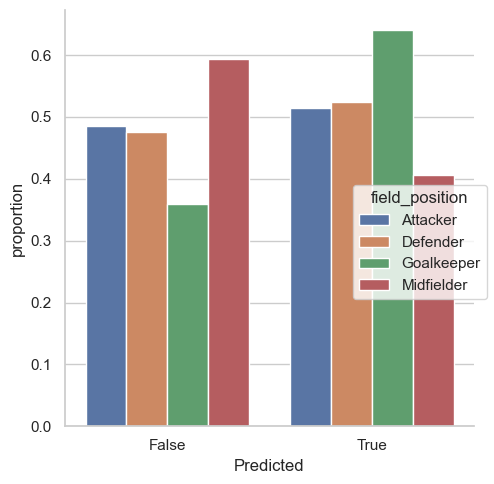

In [2549]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_ds_statParity, kind = "bar", x = "Predicted", y = "proportion", hue = "field_position", legend_out = False)


sns.move_legend(p, "center right")

### Calibration

As defined by Chouldechova in [this paper](https://via.hypothes.is/https://arxiv.org/pdf/1703.00056.pdf), "a score S = S(x) is said to be well-calibrated if it reflects the same
likelihood of recidivism irrespective of the individuals’ group membership."

In our context, when we are doing binary classification for sex-based income, the calibration takes on the form of the PPV.
Namely, our model would be well-calibrated if the fraction of predicted individuals making >\\$50k who actually make >\\$50k is the same across groups.

In [333]:
bias_ds_calibration_tf = bias_tf_ds.query("Predicted == True")

In [334]:
bias_ds_calibration_tf = bias_ds_calibration_tf.groupby(["nationality_name", "Predicted"])["Actual"].mean().reset_index(name = "mean")

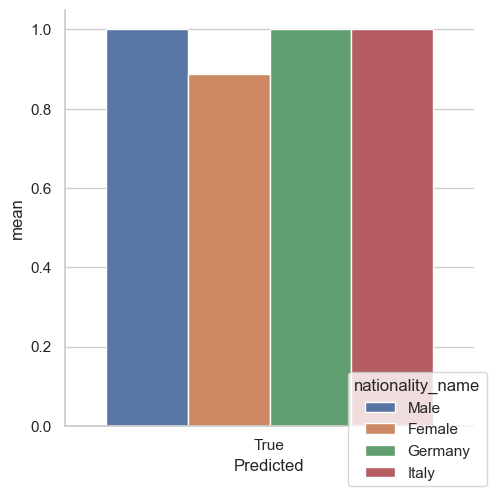

In [335]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_ds_calibration_tf, kind = "bar", x = "Predicted", y = "mean", hue = "nationality_name", legend_out = False)
new_labels = ['Male', 'Female']
for t, l in zip(p._legend.texts, new_labels):
    t.set_text(l)

sns.move_legend(p, "lower right")

### Error Rate Balance

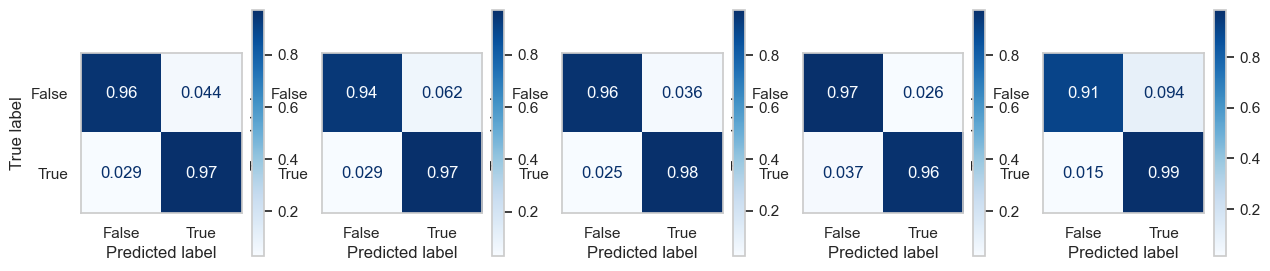

In [1789]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, axarr = plt.subplots(1, 5, figsize=(15,3.2), sharex = False, sharey = False)

cm1 = confusion_matrix(actual, predictions, labels=clf_class.classes_, normalize = "true")
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,
                              display_labels=clf_class.classes_)

cm2 = confusion_matrix(actual[group_test == "Attacker"], predictions[group_test == "Attacker"], labels=clf_class.classes_, normalize = "true")
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=clf_class.classes_)


cm3 = confusion_matrix(actual[group_test == "Midfielder"], predictions[group_test == "Midfielder"], labels=clf_class.classes_, normalize = "true")
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,
                              display_labels=clf_class.classes_)

cm4 = confusion_matrix(actual[group_test == "Defender"], predictions[group_test == "Defender"], labels=clf_class.classes_, normalize = "true")
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4,
                              display_labels=clf_class.classes_)

cm5 = confusion_matrix(actual[group_test == "Goalkeeper"], predictions[group_test == "Goalkeeper"], labels=clf_class.classes_, normalize = "true")
disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5,
                              display_labels=clf_class.classes_)

disp1.plot(ax=axarr[0], cmap = plt.cm.Blues)
axarr[0].grid(visible=None)

disp2.plot(ax=axarr[1], cmap = plt.cm.Blues)
axarr[1].grid(visible=None)

disp3.plot(ax=axarr[2], cmap = plt.cm.Blues)
axarr[2].grid(visible=None)

disp4.plot(ax=axarr[3], cmap = plt.cm.Blues)
axarr[3].grid(visible=None)

disp5.plot(ax=axarr[4], cmap = plt.cm.Blues)
axarr[4].grid(visible=None)

## Statistical Parity

In [44]:
bias_ds_statParity = bias_ds.groupby(["field_position"], as_index=False)["Predicted"].value_counts(normalize = True) #normalize = True not working sadly

In [45]:
bias_ds_statParity #query it just for true

field_position  Predicted  proportion
0       Attacker      False    0.572464
1       Attacker       True    0.427536
2       Defender       True    0.548495
3       Defender      False    0.451505
4     Goalkeeper       True    0.626263
5     Goalkeeper      False    0.373737
6     Midfielder      False    0.534591
7     Midfielder       True    0.465409

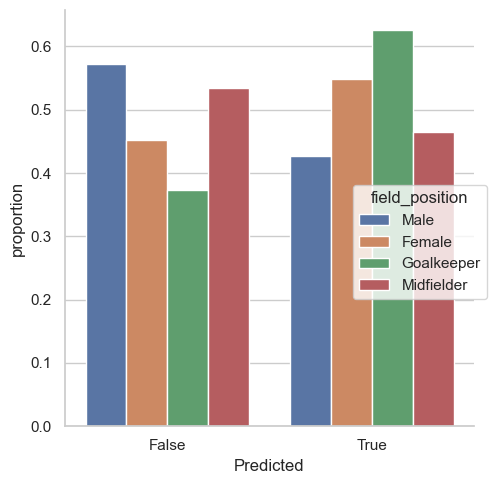

In [49]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_ds_statParity, kind = "bar", x = "Predicted", y = "proportion", hue = "field_position", legend_out = False)
new_labels = ['Male', 'Female']
for t, l in zip(p._legend.texts, new_labels):
    t.set_text(l)

sns.move_legend(p, "center right")

In [ ]:
#all features time to run vs. feature selection time to run

In [ ]:
X_train_value.iloc[:, 0:3] #get all rows for certain columns; use this in the loop, but no b/cuz we need to go from most important to least important

In [ ]:
((ordered_mutual_info).index[0]) #use this to loop

#X_train_value.iloc[:, 0:ordered_mutual_info.index[0]]

In [ ]:
# #effect of overfitting, keeping # features constant and increasing samples (good for when we get new dataset);

# #effect of overfitting, keeping # samples constant and increasing features (good for when we get new dataset);


# #initialize arrays to store scores
# train_score_hist = []
# cv_score_hist = []


# #loop through features:
# for i in range(1, len(ordered_mutual_info)):
#     #fit on training; I don't think I should refit everytime!!!!!
#     L6 = Lasso(alpha = 1) 
#     L6.fit(X_train_value.iloc[:, 0:ordered_mutual_info.index[i]], y_train_value.iloc[0:i])
    
#     #score on training
#     #print(L6.score(X_train_fee.iloc[0:i],y_train_fee.iloc[0:i]))
#     train_score_hist.append(L6.score(X_train_fee.iloc[:, 0:i],y_train_value.iloc[:, 0:i]))  #update model's training score
    
#     #cross-validation
#     cv_score_hist.append(cross_val_score(L6, X_train_fee.iloc[0:i], y_train_fee.iloc[0:i], cv=5).mean())
 

#     #Graph it
#     num_steps = len(train_score_hist)
#     plt.plot(np.arange(num_steps) + 1, cv_score_hist, label = "cross_val")

#     num_steps = len(train_score_hist)
#     plt.plot(np.arange(num_steps) + 1, train_score_hist, label = "train")

#     plt.ylim([0, 1])
#     #change x to be in batches of 5
#     labels = plt.gca().set(title = "Scores vs. Samples", xlabel = "# of Samples (in batches of 5)", ylabel = "Score")


    
# #loop through features:

# #for i in rang

# #effect of overfitting, w/ our # of samples, changing the number of features 

### Modeling Results

In [71]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=7, random_state=0)
rfr.fit(X_train_fee_sel, y_train_fee)


from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(rfr, X_train_fee_sel, y_train_fee, cv=5)
print(f"The model's 5-fold cross-validation score is {(model_scores.mean())}")

sorted_ascend_params = np.argsort(rfr.feature_importances_) #Returns the indices that would sort an array in ascending order
sorted_descend_params = list(reversed(sorted_ascend_params))
print("Top 5 features that contribute the MOST to predicting transfer fee paid:")
print(X_train_fee_sel.columns[sorted_descend_params[:5]]) #use as column names ; #match 

The model's score on the holdout test set is 0.760786694348303
The model's 5-fold cross-validation score is 0.7402369771293392
Top 5 features that contribute the MOST to predicting transfer fee paid:
Index(['fee_cleaned_buyer_avg', 'potential', 'fee_cleaned_seller_avg',
       'value_eur', 'age'],
      dtype='object')


In [147]:
from sklearn.linear_model import ElasticNet
L = ElasticNet(alpha = 0.01)
L.fit(X_train_fee_sel, y_train_fee)
print(f"The model's score on the holdout test set is {L.score(X_test_fee_sel, y_test_fee)}")

from sklearn.model_selection import cross_val_score
model_scores = cross_val_score(L, X_train_fee_sel, y_train_fee, cv=5)
print(f"The model's 5-fold cross-validation score are {(model_scores)}")

sorted_ascend_params = np.argsort(L.coef_) #Returns the indices that would sort an array in ascending order
sorted_descend_params = list(reversed(sorted_ascend_params))
print("Top 5 features that contribute the MOST to predicting transfer fee paid:")
print(X_test_fee_sel.columns[sorted_descend_params[:5]]) #use as column names ; #match 

The model's score on the holdout test set is 0.6851688282234115
The model's 5-fold cross-validation score are [0.80830407 0.35757525 0.80080656 0.49461904 0.82017666]
Top 5 features that contribute the MOST to predicting transfer fee paid:
Index(['fee_cleaned_buyer_avg', 'fee_cleaned_seller_avg', 'value_eur',
       'potential', 'age'],
      dtype='object')


## Model Performance hmm, don't need this here!

## Model Performance hmm, don't need this here!

In [48]:
#test set score arrays
L_pf = []

#cross-val score arrays
L_pf_cv = []


for i in range(1,10):
    #prepare for modeling
    
    from sklearn.model_selection import train_test_split
    value_all_train, value_all_test = train_test_split(value_all_players, test_size = .2, shuffle = True)

    #dropping categeorical info we won't use for modeling
    value_all_train = value_all_train.drop(["Name", "field_position"], axis = 1)
    value_all_test = value_all_test.drop(["Name", "field_position"], axis = 1)



    #standardized and back to df
    #Turn off for predictions?
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    value_all_train = pd.DataFrame(sc.fit_transform(value_all_train), columns = value_all_train.columns)
    value_all_test = pd.DataFrame(sc.transform(value_all_test), columns = value_all_test.columns) #do NOT need to refit the standardization

    #getting the target vector and deleting it from feature matrix

    X_train_value = value_all_train.dropna(how='any', inplace=True)
    X_train_value = value_all_train.drop(["Value"], axis = 1)
    y_train_value = value_all_train["Value"]



    X_test_value = value_all_test.dropna(how='any', inplace=True)
    X_test_value = value_all_test.drop(["Value"], axis = 1)
    y_test_value = value_all_test["Value"]
    
    #using selected features ANOVA + RFE
    X_train_value_sel = X_train_value[f_reg_rfe_index] 
    X_test_value_sel = X_test_value[f_reg_rfe_index]
    


    L = Lasso(alpha = 0.01)
    L.fit(X_train_value_sel, y_train_value)
    L_pf.append(L.score(X_test_value_sel, y_test_value))
    
    
    model_scores = cross_val_score(L, X_train_value_sel, y_train_value, cv=5)
    L_pf_cv.append((model_scores.mean()))

NameError: name 'LR' is not defined

In [413]:
print(np.mean(L_pf))
print(np.mean(L_pf_cv))

0.9857558940050496
0.9849533376763533


#### Mini Experiment: Holdout Set Vs. Cross-Validation Method

#### Take-Aways: 
- Performace:  
- Mini-Experiment: Huge discrepancy between holdout method and cross validation method, due to sample size??? double check with larger dataset, and do an experiment

In [138]:
lr_pf = []
Lasso_pf = []
rfr_pf = []

X_train_fee_sel = X_train_fee[['value_eur', 'overall', 'potential', 'wage_eur', 'passing',
       'goalkeeping_kicking', 'position_y', 'wins', 'missed', 'pts', 'xG',
       'npxG', 'xGA', 'npxGD', 'oppda_coef', 'deep', 'xpts', 'xpts_diff',
       'SPI', 'tranfer_activity', 'fee_cleaned_buyer_avg',
       'fee_cleaned_seller_avg']]

X_test_fee_sel = X_test_fee[['value_eur', 'overall', 'potential', 'wage_eur', 'passing',
       'goalkeeping_kicking', 'position_y', 'wins', 'missed', 'pts', 'xG',
       'npxG', 'xGA', 'npxGD', 'oppda_coef', 'deep', 'xpts', 'xpts_diff',
       'SPI', 'tranfer_activity', 'fee_cleaned_buyer_avg',
       'fee_cleaned_seller_avg']]

for i in range(1,10):
    from sklearn.model_selection import train_test_split
    field_tf_upd_train, field_tf_upd_test = train_test_split(tf2_data_field, test_size = .2, shuffle = True)

    #getting the feature matrix and target vector
    # field_tf_upd_train = field_tf_upd_train[field_tf_upd_train.columns[0:8]] #use this!!!
    # field_tf_upd_test = field_tf_upd_test[field_tf_upd_test.columns[0:8]] #use this!!!



    #re-clean; non-numerical stuff
    field_tf_upd_train = field_tf_upd_train.drop(["team"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["player_name"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["nationality_name"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["position_x"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["league_name_x_y"], axis = 1)
    field_tf_upd_train = field_tf_upd_train.drop(["club_involved_name"], axis = 1)

    #re-clean; non-numerical stuff
    field_tf_upd_test = field_tf_upd_test.drop(["team"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["player_name"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["nationality_name"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["position_x"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["league_name_x_y"], axis = 1)
    field_tf_upd_test = field_tf_upd_test.drop(["club_involved_name"], axis = 1)


    #TURN OFF FOR PREDICTIONS
    #standardized and back to df
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    field_tf_upd_train = pd.DataFrame(sc.fit_transform(field_tf_upd_train), columns = field_tf_upd_train.columns)


    sc = StandardScaler()
    field_tf_upd_test = pd.DataFrame(sc.fit_transform(field_tf_upd_test), columns = field_tf_upd_test.columns)


    X_train_fee = field_tf_upd_train.drop(["fee_cleaned"], axis = 1)
    y_train_fee = field_tf_upd_train["fee_cleaned"]

    X_test_fee = field_tf_upd_test.drop(["fee_cleaned"], axis = 1)
    y_test_fee = field_tf_upd_test["fee_cleaned"] # do this to get it by index; want to reset the index


    
    
    lr.fit(X_train_fee_sel, y_train_fee)
    lr.score(X_test_fee_sel, y_test_fee)

    from sklearn.model_selection import cross_val_score
    model_scores = cross_val_score(lr, X_train_fee_sel, y_train_fee, cv=5)
    lr_pf.append((model_scores.mean()))
    
    Lassolr99 = Lasso(alpha = 0.005)
    Lassolr99.fit(X_train_fee, y_train_fee)
    model_scores = cross_val_score(Lassolr99, X_train_fee, y_train_fee, cv=5)
    Lasso_pf.append(model_scores.mean())
    
    regr = RandomForestRegressor(max_depth = 11, random_state=0)
    regr.fit(X_train_fee, y_train_fee)
    model_scores = cross_val_score(regr, X_train_fee, y_train_fee, cv=5)
    rfr_pf.append(model_scores.mean())




In [139]:
print(np.mean(lr_pf))
print(np.mean(Lasso_pf))
print(np.mean(rfr_pf))

-0.1268773090295002
0.63520543291876
0.642731242587884
